In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
eps = {'x': 0.4, 'y': 0.4}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 0.6, 'y': 0.4}

# store rectangles as [x_min, x_max, y_min, y_max]
rects = np.array([[0, 0.5, 0, 0.5],
                    [0, 1, 0.75, 1],
                    [0.8, 1, 0, 0.2]])

# limit to the bounded area
rects[:, :2] = np.clip(rects[:, :2], gl_bounds['x'][0], gl_bounds['x'][1])
rects[:, 2:] = np.clip(rects[:, 2:], gl_bounds['y'][0], gl_bounds['y'][1])

In [3]:
grid = {'x': np.unique(np.concatenate([gl_bounds['x'], rects[:, 0], rects[:, 1]])), # np.unique sorts the values
        'y': np.unique(np.concatenate([gl_bounds['y'], rects[:, 2], rects[:, 3]]))}
possible_cells = np.full((grid['y'].shape[0] - 1, grid['x'].shape[0] - 1), True)

def mark_area_impossible(grid, possible_cells, rect):
    x_id, = np.where(np.isclose(grid['x'], rect[0]))[0]
    y_id, = np.where(np.isclose(grid['y'], rect[2]))[0]
    st_x_id = x_id
    has_changed = False
    while grid['y'][y_id] < rect[3]:
        while grid['x'][x_id] < rect[1]:
            if possible_cells[y_id, x_id]:
                has_changed = True
            possible_cells[y_id, x_id] = False
            x_id += 1
        x_id = st_x_id
        y_id += 1
    return has_changed

for rect in rects:
    mark_area_impossible(grid, possible_cells, rect)
possible_cells

array([[False,  True, False],
       [False,  True,  True],
       [ True,  True,  True],
       [False, False, False]])

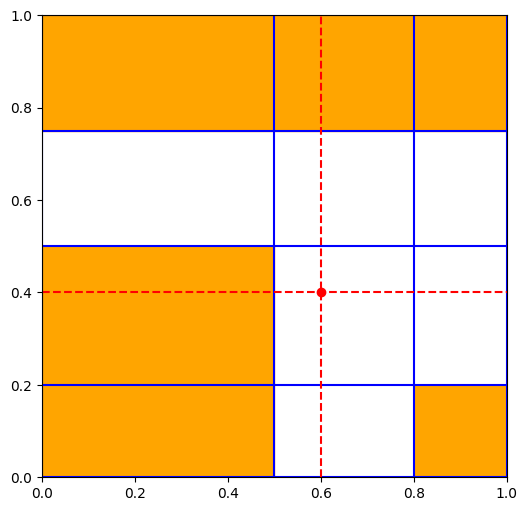

In [4]:
# draw grid, impossible areas and true coordinates
def draw(fig, ax, grid, possible_cells, true_coords, gl_bounds):
    ax.vlines(grid['x'], gl_bounds['y'][0], gl_bounds['y'][1], colors='blue')
    ax.hlines(grid['y'], gl_bounds['x'][0], gl_bounds['x'][1], colors='blue')

    ax.plot(true_coords['x'], true_coords['y'], marker='o', color='red')
    ax.vlines(true_coords['x'], 0, 1, colors='red', linestyle='dashed')
    ax.hlines(true_coords['y'], 0, 1, colors='red', linestyle='dashed')

    for row_id in range(possible_cells.shape[0]):
        for col_id in range(possible_cells.shape[1]):
            if not possible_cells[row_id, col_id]:
                x = [grid['x'][col_id], grid['x'][col_id], grid['x'][col_id + 1], grid['x'][col_id + 1]]
                y = [grid['y'][row_id], grid['y'][row_id + 1], grid['y'][row_id + 1], grid['y'][row_id]]
                ax.fill(x, y, color='orange')

    ax.set(xlim=gl_bounds['x'], ylim=gl_bounds['y'])

fig, ax = plt.subplots(figsize=(6, 6))
draw(fig, ax, grid, possible_cells, true_coords, gl_bounds)
# plt.show()

In [5]:
def is_smaller_eps(coord, axis, grid, possible_cells, eps, gl_bounds):
    # coord: float in [0, 1] - coord in axis
    # axis: 'x' or 'y'
    cell_id = np.searchsorted(grid[axis][:-1], coord, side='right') - 1 # index of corresponding column/row of cells
    first_avail, last_avail = None, None
    oa_idx = 0 if axis == 'x' else 1 # other axis id for possible_cells
    for i in range(possible_cells.shape[oa_idx]):
        row_id, col_id = cell_id, i
        if axis == 'x':
            row_id, col_id = col_id, row_id
        if possible_cells[row_id, col_id]:
            first_avail = i
            break
    for i in range(possible_cells.shape[oa_idx] - 1, -1, -1):
        row_id, col_id = cell_id, i
        if axis == 'x':
            row_id, col_id = col_id, row_id
        if possible_cells[row_id, col_id]:
            last_avail = i
            break
    if first_avail is None or last_avail is None:
        return False # no possible cells for that coordinate
    return grid[axis][last_avail + 1] - grid[axis][first_avail] < eps[axis]

In [6]:
def remove_impossible_areas(axis, remove_small, grid, possible_cells, true_coords, eps, gl_bounds):
    axis_idx = 0 if axis == 'y' else 1
    has_changed = False
    for cell_id in range(possible_cells.shape[axis_idx]):
        mid_coord = (grid[axis][cell_id + 1] - grid[axis][cell_id]) / 2
        if is_smaller_eps(mid_coord, axis, grid, possible_cells, eps, gl_bounds) == remove_small:
            rect = [gl_bounds['x'][0], gl_bounds['x'][1], grid['y'][cell_id], grid['y'][cell_id + 1]] if axis == 'y' \
                    else [grid['x'][cell_id], grid['x'][cell_id + 1], gl_bounds['y'][0], gl_bounds['y'][1]]
            has_changed_local = mark_area_impossible(grid, possible_cells, rect)
            has_changed = has_changed or has_changed_local
            # if has_changed_local:
            #     has_changed = True
    return has_changed

In [7]:
def run_process(eps, gl_bounds, true_coords, grid, possible_cells):
    axis = 'x'
    does_know = {'x': False, 'y': False}
    has_changed_prev = True

    nrows, ncols = 2, 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 12))

    ax_i = 0
    ax_j = 0

    while not (does_know['x'] and does_know['y']):
        if is_smaller_eps(true_coords[axis], axis, grid, possible_cells, eps, gl_bounds):
            print(axis, "knows")
            does_know[axis] = True
            has_changed = remove_impossible_areas(axis, False, grid, possible_cells, true_coords, eps, gl_bounds)
        else:
            print(axis, "doesn't know")
            has_changed = remove_impossible_areas(axis, True, grid, possible_cells, true_coords, eps, gl_bounds)

        draw(fig, axs[ax_i, ax_j], grid, possible_cells, true_coords, gl_bounds)
        ax_j = (ax_j + 1) % ncols
        if ax_j == 0:
            ax_i += 1

        if not (has_changed_prev or has_changed):
            break
        has_changed_prev = has_changed
        axis = 'x' if axis == 'y' else 'y'

x doesn't know
y doesn't know
x doesn't know
y doesn't know


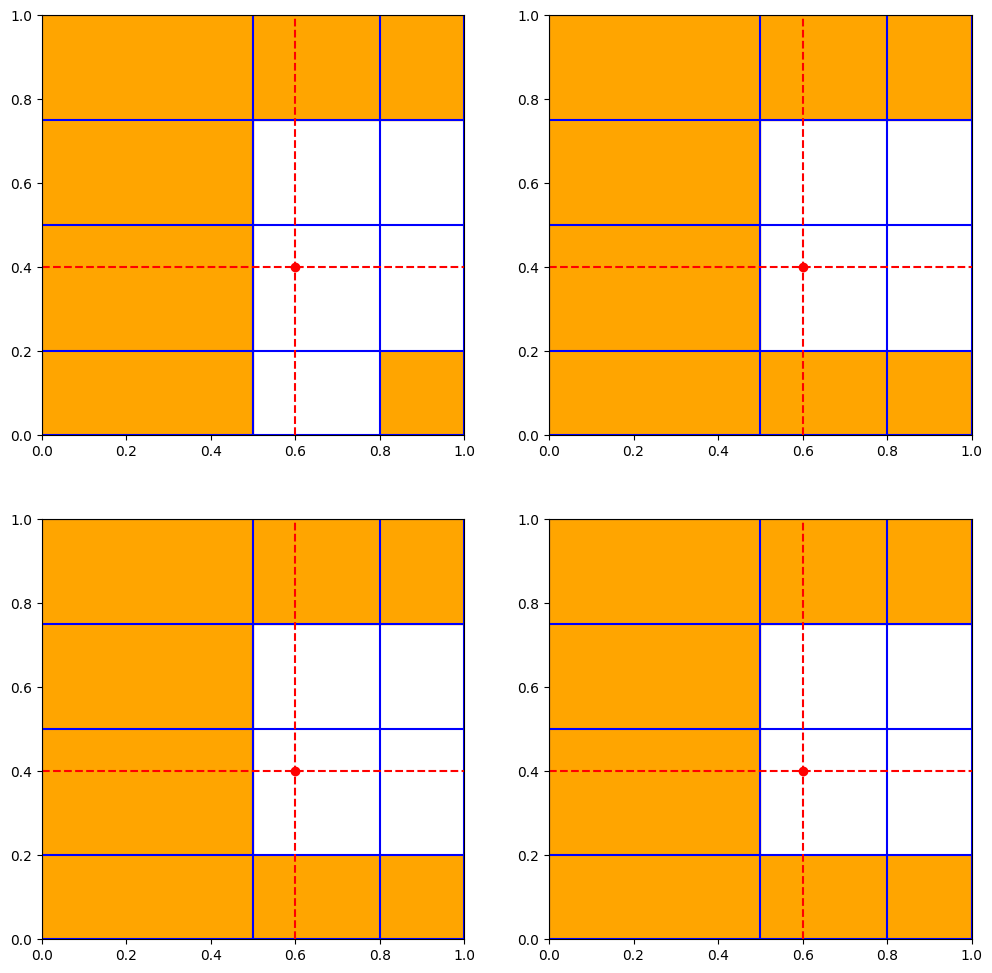

In [8]:
run_process(eps, gl_bounds, true_coords, grid, possible_cells)